In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm

In [3]:
df = pd.read_csv("Amazon.csv")

In [16]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [14]:
data = df.Open

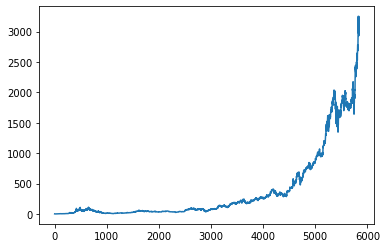

In [15]:
plt.plot(data)

In [24]:
Data = (np.array(data))
Data = np.reshape(Data , (Data.shape[0],1))
slt = int(0.85*len(data))
Train = Data[:slt]
Test = Data[slt:]

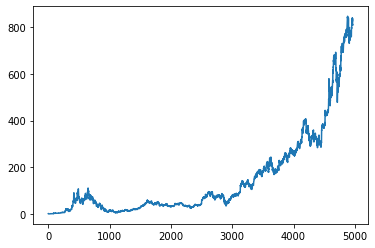

In [25]:
plt.plot(Train)

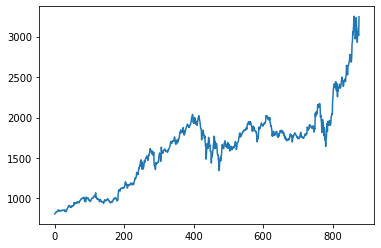

In [26]:
plt.plot(Test)

In [27]:
Test.shape

(877, 1)

In [39]:
import pickle
import numpy as np
from hmmlearn import hmm


class GmmHmmForecast:
    """
    GMM-HMM forecasting model based on the paper:
    "Stock Market Prediction Using Hidden Markov Model
    Aditya Gupta, Non-Student Member, IEEE and Bhuwan Dhingra,
    Non-Student member, IEEE"
    links:
    - https://ieeexplore.ieee.org/document/6199099
    - http://www.cs.cmu.edu/~bdhingra/papers/stock_hmm.pdf
    """

    @staticmethod
    def load(modelLoadPath):
        """
        Loads the model from the provided filepath

        :param modelLoadPath: path from where to load the model
        :return: model which is loaded from the given path
        """

        model = GmmHmmForecast(
            None, None, None,
            loadModel=True
        )

        with open(modelLoadPath, 'rb') as fl:
            loadDict = pickle.load(fl)

        model.model = loadDict['model']
        model.dimension = loadDict['dimension']
        model.d = loadDict['d']

        return model

    def __init__(
            self,
            numStates,
            numMixtureComp,
            dimension,
            d=10,
            numIterations=10,
            threshold=1e-7,
            covariance_type='full',
            verbose=False,
            loadModel=False
    ):
        """
        Initialize GMM-HMM model using the provided parameters, note that
        the training information has to be provided during the now itself,
        and the train function then has to be called exactly once

        :param numStates: number of states of the HMM
        :param numMixtureComp: number of mixture components present in
        each of the emission probabilities
        :param dimension: dimension of the observations
        :param d: number of timesteps to use for forecasting the next
        observation at the next timestep. This is called 'latency'
        :param numIterations: number of iterations of training to be
        performed
        :param threshold: value such that the training procedure
        is said to have converged if the increase in log likelihood
        is lesser than this value
        :param covariance_type: type of covariance matrix to use
        for the mixture components of the GMM emission distribution
        :param verbose: if True, then display training info, else
        do not display training info (training info: log likelihood
        at each iteration)
        :param loadModel: True or False - do not use this parameter !,
        this is for internal use only (i.e. it is an implementation detail)
        If True, then object is normally created, else object is created
        without any member values being created. This is used when model
        is created by the static load method
        """

        if loadModel:
            return

        self.model = hmm.GMMHMM(
            n_components=numStates,
            n_mix=numMixtureComp,
            covariance_type=covariance_type,
            n_iter=numIterations,
            tol=threshold,
            verbose=verbose
        )

        self.dimension = dimension
        self.d = d

    def train(self, trainSequences):
        """
        Train the model on the provided training sequences. This
        function is to be called exactly once.

        :param trainSequences: list of numpy arrays of shape (ni, dimension),
        where each numpy array can represents an observation sequence. Hence,
        each numpy array can have any length (axis 0) but has to have exactly
        'dimension' as the dimension of axis 1
        :return: list of log likelihood values corresponding to each iteration
        """

        X = np.concatenate(trainSequences, axis=0)
        assert X.shape[1] == self.dimension
        lengths = [seq.shape[0] for seq in trainSequences]

        self.model.fit(X=X, lengths=lengths)

        return list(self.model.monitor_.history)

    def predict(self, X, discParamSet, returnMaxLikelihood=False):
        """
        Forecast using the model parameters on the provided input data. A thing
        to note is that only the last prediction is useful, since one already
        has the true observations for the predictions made by this function, but
        this allows one to see the performance of this algorithm.

        :param X: observation sequence, it is a numpy array of shape (n, dimension)
        :param discParamSet: for each of the 'dimension' number of components in
        an observation, there should be a numpy array of containing the discrete
        set of allowed values for that value i.e. for the ith component of the
        observation vector, discParamSet[i] is a 1D python list or numpy array
        of shape (ni,) containing all the values from which we predict this ith
        component.
        :param returnMaxLikelihood: if True, our return value is
        (pred, maxLikelihoodValues), i.e. all the predictions, and the log
        likelihood of each prediction. if False, then our return value is
        just the predictions numpy array.
        :return: prediction of the value following every 'd' length
        contiguous subsequence of the provided observation sequence. Hence,
        the predictions numpy array 'pred' has shape (n - d, dimension).
        """

        assert X.shape[1] == self.dimension
        assert len(discParamSet) == self.dimension

        pred = []
        maxLikelihoodValues = [] if returnMaxLikelihood else None

        for t in range(self.d, X.shape[0]):
            # Construct observations using [t-d..t] i.e. current timestep is
            # excluded, since we would be predicting the current timestep
            x = np.concatenate(
                (X[t - self.d: t], np.zeros((1, self.dimension))),
                axis=0
            )

            obs, maxLikelihood = self.getMostLikelyObs(x, discParamSet, 0)
            pred.append(obs)

            if returnMaxLikelihood:
                maxLikelihoodValues.append(maxLikelihood)

        pred = np.array(pred)

        if returnMaxLikelihood:
            return pred, maxLikelihoodValues
        else:
            return pred

    def save(self, modelSavePath):
        """
        Save the model at the provided filepath

        :param modelSavePath: path where to store the model
        """

        saveDict = {
            'model': self.model,
            'dimension': self.dimension,
            'd': self.d
        }

        with open(modelSavePath, 'wb') as fl:
            pickle.dump(saveDict, fl)

    def getMostLikelyObs(self, x, discParamSet, idx):
        """
        This is a helper function (do not directly call it!). This
        function assumes that among the 'dimension' many components
        of the dth (0-based) observation in x, idx many components have
        been given their values, and all the previous (0..d-1)
        observation vectors in x have also been given their value, now
        we want to compute the most optimal set of values for observation
        components idx..dimension-1, by most optimal we mean values
        for idx..dimension-1 component of x[d] which gives highest log
        likelihood value of the sequence x(0)..x(d).


        :param x: observation sequence, it is a numpy array of shape
        (d + 1, dimension), we want to set the most optimal value of
        x[d + 1, idx : dimension]
        :param discParamSet: for each of the 'dimension' number of components in
        an observation, there should be a numpy array of containing the discrete
        set of allowed values for that value i.e. for the ith component of the
        observation vector, discParamSet[i] is a 1D python list or numpy array
        of shape (ni,) containing all the values from which we predict this ith
        component.
        :param idx: index of the component of x[d] whose value we are going to
        fix now, and recursively fix values of components idx+1 .. dimension-1
        such that they yield maximum likelihood
        :return: a 2-tuple containing (chosen observation, likelihood of the
        chosen observation), the chosen observation has maximum likelihood
        given that we are allowed to vary ony these: x[d + 1, idx : dimension]
        (rest all are fixed)
        """

        if idx == len(discParamSet):
            return x[self.d].copy(), self.model.score(x)

        chosenObs = None
        maxLikelihood = None

        for paramValue in discParamSet[idx]:
            x[self.d, idx] = paramValue

            currObs, currLikelihood = \
                self.getMostLikelyObs(x, discParamSet, idx + 1)

            if maxLikelihood is None or currLikelihood > maxLikelihood:
                maxLikelihood = currLikelihood
                chosenObs = currObs

        return chosenObs, maxLikelihood


In [40]:
numStates = 6
numMixtureComp = 3
dimension = 1
numIterations = 200
threshold = 0.0
covariance_type = 'full'
verbose = True

In [41]:
model2 = GmmHmmForecast(
    numStates=numStates,
    numMixtureComp=numMixtureComp,
    dimension=dimension,
    numIterations=numIterations,
    threshold=threshold,
    covariance_type=covariance_type,
    verbose = True)

In [42]:
logLikelihoodValues2 = model2.train([Train])

         1      -34252.4967             +nan
         2      -30326.9374       +3925.5593
         3      -28658.1707       +1668.7668
         4      -26771.6358       +1886.5349
         5      -25154.8405       +1616.7953
         6      -24202.6618        +952.1787
         7      -23633.6114        +569.0504
         8      -23264.6071        +369.0043
         9      -23084.1946        +180.4125
        10      -23047.2261         +36.9686
        11      -23040.6410          +6.5850
        12      -23034.8488          +5.7923
        13      -23028.3980          +6.4507
        14      -23014.9675         +13.4306
        15      -22984.1721         +30.7954
        16      -22923.6217         +60.5504
        17      -22860.7314         +62.8903
        18      -22829.2505         +31.4809
        19      -22808.5166         +20.7338
        20      -22786.8787         +21.6380
        21      -22753.9723         +32.9064
        22      -22671.5176         +82.4547
        23

       187      -20505.6931          +0.0020
       188      -20505.6913          +0.0019
       189      -20505.6896          +0.0017
       190      -20505.6880          +0.0015
       191      -20505.6866          +0.0014
       192      -20505.6853          +0.0013
       193      -20505.6841          +0.0012
       194      -20505.6830          +0.0011
       195      -20505.6820          +0.0010
       196      -20505.6810          +0.0010
       197      -20505.6801          +0.0009
       198      -20505.6793          +0.0009
       199      -20505.6785          +0.0008
       200      -20505.6777          +0.0008


Has model converged:  True


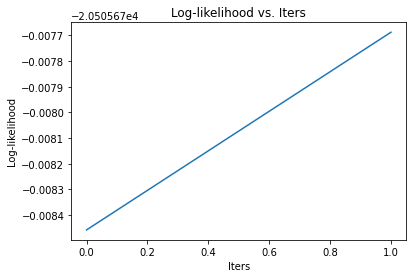

In [43]:
plt.plot(logLikelihoodValues2, label='log-likelihood')
plt.xlabel('Iters')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs. Iters')
print('Has model converged: ', model2.model.monitor_.converged)

In [45]:
discParamSet = [np.linspace(1,3300,100)]
discParamSet

[array([1.00000000e+00, 3.43232323e+01, 6.76464646e+01, 1.00969697e+02,
        1.34292929e+02, 1.67616162e+02, 2.00939394e+02, 2.34262626e+02,
        2.67585859e+02, 3.00909091e+02, 3.34232323e+02, 3.67555556e+02,
        4.00878788e+02, 4.34202020e+02, 4.67525253e+02, 5.00848485e+02,
        5.34171717e+02, 5.67494949e+02, 6.00818182e+02, 6.34141414e+02,
        6.67464646e+02, 7.00787879e+02, 7.34111111e+02, 7.67434343e+02,
        8.00757576e+02, 8.34080808e+02, 8.67404040e+02, 9.00727273e+02,
        9.34050505e+02, 9.67373737e+02, 1.00069697e+03, 1.03402020e+03,
        1.06734343e+03, 1.10066667e+03, 1.13398990e+03, 1.16731313e+03,
        1.20063636e+03, 1.23395960e+03, 1.26728283e+03, 1.30060606e+03,
        1.33392929e+03, 1.36725253e+03, 1.40057576e+03, 1.43389899e+03,
        1.46722222e+03, 1.50054545e+03, 1.53386869e+03, 1.56719192e+03,
        1.60051515e+03, 1.63383838e+03, 1.66716162e+03, 1.70048485e+03,
        1.73380808e+03, 1.76713131e+03, 1.80045455e+03, 1.833777

In [46]:
pred2 = model2.predict(Test , discParamSet)

In [47]:
pred2

array([[767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767.43434343],
       [767

In [29]:
model = hmm.GMMHMM(
            n_components=6,
            n_mix=4,
            covariance_type='full',
            n_iter=500,
            tol=0.0,)

In [30]:
model.fit(Train)

GMMHMM(covariance_type='full',
       covars_prior=array([[[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]],


       [[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]],


       [[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]],


       [[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]],


       [[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]],


       [[[0.]],

        [[0.]],

        [[0.]],

        [[0.]]]]),
       covars_weight=array([[-3., -3., -3., -3.],
       [-3., -3., -3., -3.],
       [-3., -3., -3., -3.],
       [-3., -3., -3., -3.],
       [-3., -3., -3., -3.],
       [-3., -3...
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]]]),
       means_weight=array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [48]:
np.max(Test)

3251.06005859375

In [49]:
d = 10
new_Test = np.concatenate([Train[-d+1:] , Test])

In [50]:
Set = np.linspace(1,3300,80)
Set

array([1.00000000e+00, 4.27594937e+01, 8.45189873e+01, 1.26278481e+02,
       1.68037975e+02, 2.09797468e+02, 2.51556962e+02, 2.93316456e+02,
       3.35075949e+02, 3.76835443e+02, 4.18594937e+02, 4.60354430e+02,
       5.02113924e+02, 5.43873418e+02, 5.85632911e+02, 6.27392405e+02,
       6.69151899e+02, 7.10911392e+02, 7.52670886e+02, 7.94430380e+02,
       8.36189873e+02, 8.77949367e+02, 9.19708861e+02, 9.61468354e+02,
       1.00322785e+03, 1.04498734e+03, 1.08674684e+03, 1.12850633e+03,
       1.17026582e+03, 1.21202532e+03, 1.25378481e+03, 1.29554430e+03,
       1.33730380e+03, 1.37906329e+03, 1.42082278e+03, 1.46258228e+03,
       1.50434177e+03, 1.54610127e+03, 1.58786076e+03, 1.62962025e+03,
       1.67137975e+03, 1.71313924e+03, 1.75489873e+03, 1.79665823e+03,
       1.83841772e+03, 1.88017722e+03, 1.92193671e+03, 1.96369620e+03,
       2.00545570e+03, 2.04721519e+03, 2.08897468e+03, 2.13073418e+03,
       2.17249367e+03, 2.21425316e+03, 2.25601266e+03, 2.29777215e+03,
      

In [51]:
import numpy as np


class Pso:

    @staticmethod
    def computeInitialPos(
            paramRange,
            numParticles
    ):
        """
        Compute initial positions of particles by sampling for each
        component of each particle from the uniform distribution
        with end points specified for each component as an argument
        taken by this function.

        :param paramRange: list of 2-tuples (low, high) of length equal
        to the dimension of the parameter space. There should be a
        tuple for every dimension. Hence, for dimension d, the tuple
        (low, high) says that each particle position's dth component must
        be sampled from uniform(low, high).
        :param numParticles: number of particles
        :return: initial position matrix of shape (numParticles, dimension)
        containing initial position vectors for each particle.
        """

        dim = len(paramRange)
        initialPos = np.zeros((numParticles, dim))

        for d in range(dim):
            low, high = paramRange[d]
            initialPos[:, d] = np.random.uniform(low, high, (numParticles,))

        return initialPos

    @staticmethod
    def pso(
            minFunc,
            initialPos,
            inertiaCoeff=1,
            inertiaDamp=0.99,
            personalCoeff=2,
            socialCoeff=2,
            numIterations=20
    ):
        """
        Particle Swarm Optimization algorithm

        :param minFunc: function which is to be minimized. It must
        accept a numpy array of shape (dim,) where dim is the dimension
        of the parameter space
        :param initialPos: initial positions for each of the particles.
        It should be a numpy array of shape (numParticles, dim)
        :param inertiaCoeff: coefficient used for updating the velocity
        based on previous velocity
        :param inertiaDamp: used for damping inertia coefficient after
        every iteration.
        :param personalCoeff: coefficient used for updating the velocity
        based on personal best
        :param socialCoeff: coefficient used for updating the velocity
        based on global best
        :param numIterations: number of iterations to be performed
        :return: (optimized parameters,
            optimal value of the function,
            global best cost values at each iteration),
        where the optimized parameters is a numpy array of shape (dim,)
        and optimal value is the value of the function achieved by these
        parameters
        """

        numParticles, dim = initialPos.shape

        pos = initialPos.copy()
        vel = np.zeros(pos.shape)

        bestPos = initialPos.copy()
        bestCosts = np.zeros((numParticles,))
        bestParticle = None

        for i in range(numParticles):
            bestCosts[i] = minFunc(pos[i])
            bestParticle = i if bestParticle is None \
                or bestCosts[i] < bestCosts[bestParticle] else bestParticle

        iterBestCosts = np.zeros((numIterations,))
        for iterNum in range(numIterations):

            vel = inertiaCoeff * vel \
                + personalCoeff * np.random.rand(numParticles, dim) * (bestPos - pos) \
                + (socialCoeff * np.random.rand(numParticles, dim)
                    * (np.expand_dims(bestPos[bestParticle], axis=0) - pos))

            pos = pos + vel

            for i in range(numParticles):
                currValue = minFunc(pos[i])

                if currValue < bestCosts[i]:
                    bestCosts[i] = currValue
                    bestPos[i, :] = pos[i, :]

                    if currValue < bestCosts[bestParticle]:
                        bestParticle = i

            iterBestCosts[iterNum] = bestCosts[bestParticle]
            inertiaCoeff *= inertiaDamp

        return bestPos[bestParticle], bestCosts[bestParticle], iterBestCosts

    @staticmethod
    def psoConstrictionCoeff(
            minFunc,
            initialPos,
            kappa=1,
            phi1=2.05,
            phi2=2.05,
            numIterations=20
    ):
        """
        PSO algorithm with the addition of constriction coefficients.
        This eliminates the use of damping for the inertia coefficient.

        :param minFunc: function which is to be minimized. It must
        accept a numpy array of shape (dim,) where dim is the dimension
        of the parameter space
        :param initialPos: initial positions for each of the particles.
        It should be a numpy array of shape (numParticles, dim)
        :param kappa: the kappa constriction coefficient. It should
        be in [0, 1]
        :param phi1: the phi1 constriction coefficient. phi1 + phi2
        must be greater than or equal to 2
        :param phi2: the phi2 constriction coefficient. phi1 + phi2
        must be greater than or equal to 2
        :param numIterations: number of iterations to be performed
        :return: (optimized parameters,
            optimal value of the function,
            global best cost values at each iteration),
        where the optimized parameters is a numpy array of shape (dim,)
        and optimal value is the value of the function achieved by these
        parameters
        """

        phi = phi1 + phi2
        chi = 2 * kappa / np.abs(2 - phi - np.sqrt(phi * phi - 4 * phi))

        inertiaCoeff = chi
        inertiaDamp = 1
        personalCoeff = chi * phi1
        socialCoeff = chi * phi2

        return Pso.pso(
            minFunc,
            initialPos,
            inertiaCoeff,
            inertiaDamp,
            personalCoeff,
            socialCoeff,
            numIterations
        )




In [64]:
int_pos = Pso.computeInitialPos([(1,3300)], 10)
int_pos

array([[ 414.04819626],
       [1483.75190535],
       [2997.02847173],
       [1500.49263357],
       [ 494.42905054],
       [2601.65628053],
       [1468.60097043],
       [1841.68455062],
       [2590.27335522],
       [ 672.73174717]])

In [65]:
NN = new_Test[:50]

In [69]:
rf = 0

def cst(x):
    temp = np.append(rf, x)
    temp = np.reshape(temp , (d,1))
    scr = model.score(temp)
    if(x > 3300 or x < 0):
        scr = 999999
    return scr

def PSO_HMM():
    params, bestCost, bestCosts = Pso.pso(cst, int_pos)
    print(bestCost)
    return params[0]
    

In [70]:
pred = []
for i in range(0,len(NN)-d+1,1):
    rf = NN[i:i+d-1]
    #print(rf)
    obs = PSO_HMM()
    pred.append(obs)

-49408.808214588826
-49863.00407929221
-49380.17737805037
-48498.40660907778
-48699.01183904454
-49180.74961680331
-46952.72149201485
-46477.20589332009
-46584.4248258585
-46959.69177521339
-47823.00304415999
-48304.038088997295
-49040.612832805535
-49698.338520843936
-49631.643385068164
-50283.747484271466
-50580.17235907521
-51188.15016648061
-52008.94422620744
-52181.60763197647
-51117.47634646407
-50691.39491398487
-51396.651625054525
-51753.0972199757
-51715.787815571006
-51215.44064263914
-50920.4094234574
-50933.53904608446
-51179.69441880838
-51561.6933597346
-52097.10082615044
-51822.818607572735
-51839.488408514764
-51962.968149244836
-52024.689634998984
-51902.577364914316
-51707.66598204916
-52136.35983377176
-50778.75114109272
-50997.20482269583
-51442.19086931335


In [71]:
pred

[3293.3061286535576,
 3297.936151586222,
 3289.5291588336468,
 3288.873707215374,
 3292.5818759725985,
 3299.871108671539,
 3296.0960486791573,
 3285.5269504021253,
 3290.325852707608,
 3297.6161907762776,
 3298.5506069663534,
 3293.8417767843275,
 3283.0335717780927,
 3298.08973794049,
 3270.0073118129494,
 3295.5420165797573,
 3288.7378514036154,
 3263.37783000344,
 3265.6705157882047,
 3291.7076319732264,
 3291.802334092894,
 3291.1584706548956,
 3285.018098729359,
 3296.227243055233,
 3284.583399763745,
 3292.530104485935,
 3294.9756568933362,
 3292.717356531005,
 3281.3034221123576,
 3296.7135026734936,
 3291.9619488489516,
 3289.8097638298113,
 3282.720138741489,
 3291.410747850822,
 3272.3167643631396,
 3293.7736996821986,
 3292.7294724560775,
 3294.4854833704876,
 3253.822981093538,
 3268.829438745801,
 3288.898530070931]